#Installation using pip command

In [1]:
!pip install scsurv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=fa945b418efd5ba24f1b5832e11d708163cc578b10f40c7c01c6d2215a60387c
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd9

#Download melanoma scRNA-seq dataset from GSE115978

In [2]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115978/suppl/GSE115978%5Fcounts.csv.gz

--2025-10-14 08:33:16--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115978/suppl/GSE115978%5Fcounts.csv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51508919 (49M) [application/x-gzip]
Saving to: ‘GSE115978_counts.csv.gz’

GSE115978_counts.cs 100%[===================>]  49.12M  14.6MB/s    in 3.4s    

2025-10-14 08:33:21 (14.6 MB/s) - ‘GSE115978_counts.csv.gz’ saved [51508919/51508919]



In [3]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115978/suppl/GSE115978%5Fcell.annotations.csv.gz

--2025-10-14 08:33:21--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE115nnn/GSE115978/suppl/GSE115978%5Fcell.annotations.csv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101286 (99K) [application/x-gzip]
Saving to: ‘GSE115978_cell.annotations.csv.gz’

GSE115978_cell.anno 100%[===================>]  98.91K   254KB/s    in 0.4s    

2025-10-14 08:33:22 (254 KB/s) - ‘GSE115978_cell.annotations.csv.gz’ saved [101286/101286]



#Import libraries

In [4]:
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import scsurv.workflow as workflow
import matplotlib.pyplot as plt

#Import prepared files
We can not make the actual bulk RNA-seq data from SKCM publicly available; users must download it themselves from the Genomic Data Commons (GDC) Data Portal(https://portal.gdc.cancer.gov/).

In this tutorial, we use the differentially expressed genes calculated using the downloaded bulk RNA-seq data and the trained checkpoints of scSurv.

In [5]:
from importlib.resources import files, as_file
base = files("scsurv") / "data"
ref_genes = (base / "SKCM_ref_5000genes.txt").read_text(encoding="utf-8").splitlines()
with as_file(base / "SKCM_checkpoint.pt") as p:
    saved_pt = str(p)
with as_file(base / "SKCM_umap_coordinates.csv") as p:
    umap_df = pd.read_csv(p, index_col=0)

In [13]:
count_df = pd.read_csv('GSE115978_counts.csv.gz', index_col=0).T
annotation_df = pd.read_csv('GSE115978_cell.annotations.csv.gz', index_col=0)
sc_adata = sc.AnnData(X=csr_matrix(count_df.values), obs=annotation_df)
sc_adata.var_names = count_df.columns
sc_adata.obs = annotation_df
sc_adata.obs['cell.types'] = sc_adata.obs['cell.types'].replace('?', 'Undifined')
sc_adata.obsm['X_umap'] = umap_df[['UMAP1','UMAP2']].to_numpy()
sc_adata = sc_adata[:, ref_genes].copy()

#Run scSurv

In [14]:
bulk_adata = None
batch_key = 'samples'
exp_name = None
epoch = 10000

In [15]:
sc_adata, bulk_adata, _, _, vaesm_exp = workflow.run_scSurv(sc_adata, bulk_adata, exp_name, epoch, batch_key, saved_path = saved_pt)

make_sample_one_hot_mat
torch.cuda.is_available() True
vae_results


/usr/local/lib/python3.12/dist-packages/torch/nn/init.py:582: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


all_x_correlation_gene 0.402 train_x_correlation_gene 0.420 val_x_correlation_gene 0.316 test_x_correlation_gene 0.318
deconvolution_results
Done post process


#Visualization

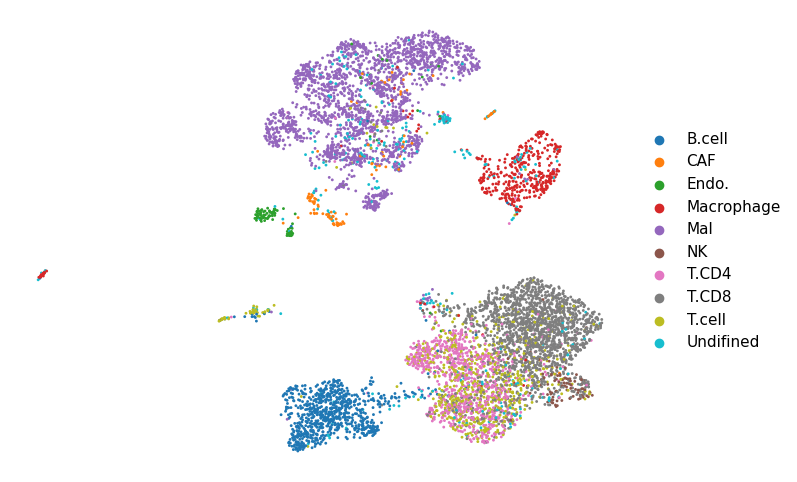

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(sc_adata, color='cell.types', ax=ax, show=False, colorbar_loc=None, frameon=False, legend_fontsize=11)
ax.set_title('', fontsize=20)
plt.savefig('SKCM_umap_celltype.png')

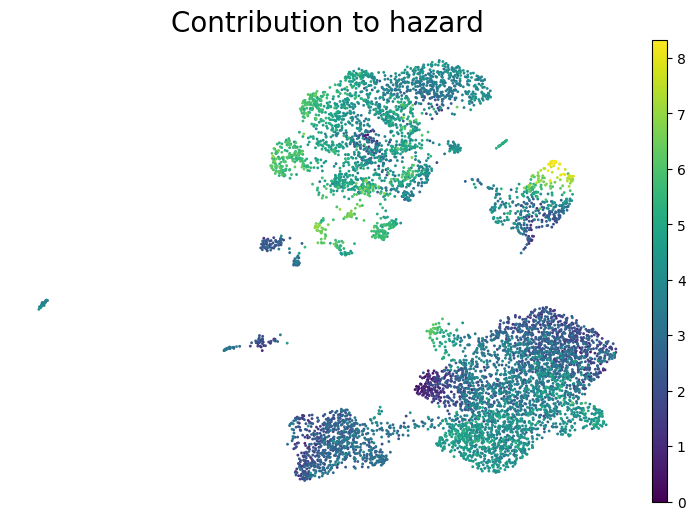

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.umap(sc_adata, color='beta_z', ax=ax, show=False, colorbar_loc='right', frameon=False)
ax.set_title('Contribution to hazard', fontsize=20)
plt.savefig('SKCM_umap_beta_z.png')

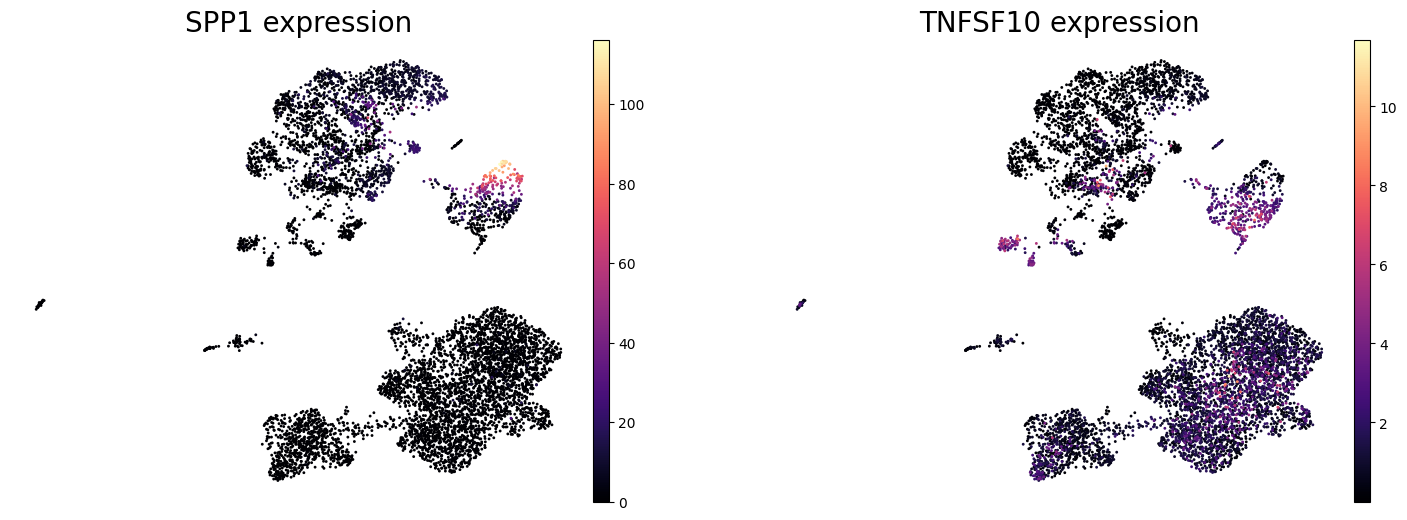

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sc.pl.umap(sc_adata, color='SPP1', ax=ax1, show=False, colorbar_loc='right', layer='xld', frameon=False, color_map='magma')
ax1.set_title('SPP1 expression', fontsize=20)

sc.pl.umap(sc_adata, color='TNFSF10', ax=ax2, show=False, colorbar_loc='right', layer='xld', frameon=False, color_map='magma')
ax2.set_title('TNFSF10 expression', fontsize=20)

plt.savefig('SKCM_umap_SPP1_TNFSF10.png')